# Regression - what could go wrong?

In [1]:
%matplotlib inline
# %matplotlib notebook

In [2]:
import os.path
import random
import sys
import numpy as np
from math import *
from scipy import stats
from sklearn.linear_model import LinearRegression

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

The chapter on multiple regression starts off with this quotation:

> _I don’t look at a problem and put variables in there that don’t affect it._
> —Bill Parcells

...but what if you did?

Joel gives an example of a model that is both underspecified and whose covariates are correlated and shows that this leads to biased estimates of the beta coefficients. Note that the explanation in the book was the subject of an errata note ([errata for p. 181](https://www.oreilly.com/catalog/errata.csp?isbn=0636920033400)).

It turns out that there are a number of known failure modes for regression. It's always fun to explore what can go wrong. PSU has some nice [lecture notes on Regression Methods](https://onlinecourses.science.psu.edu/stat501/node/2/). The key question is: how do you know what variables belong in a regression model? Mostly, you don't. So, what happens when you get it wrong? Well, the PSU notes give 4 possibilities:

* correctly specified
* underspecified (missing important variables)
* extraneous variables (that are neither related to the response nor to any of the other predictors)
* overspecified (redundant predictor variables)

When you consider all the possibilities of correlated and under/over specified models, this sorta implies a grid:

| covariates |  uncorrelated  |   correlated   |
|------------|----------------|----------------|
|    correct |      ok        |      ?         |
|       over |      ok        | spurious betas |
|      under |       ?        | spurious betas |

There are at least a couple of other nasties to consider. One is interactions between covariates. Most generally, the 'actual' feature that you really want is some function of one or more of your measured variables.

$ c = f(a,b) $

$ y = \alpha  + \beta_1 a + \beta_2 b + \beta_3 c + \epsilon $

Also, there's always noise. No measurement is perfect. Let's play with these factors and see what happens.

## Fitting a line to some data

In [4]:
n=500
x = np.random.normal(size=n)
x.sort()

$ y = \beta_1 x + \alpha + \epsilon $

In [5]:
y = 2.3456*x + 1.0 + np.random.normal(size=n)

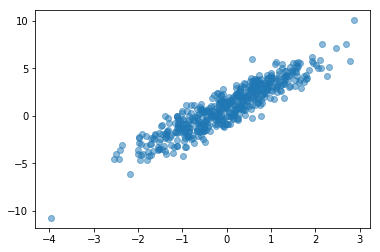

In [6]:
plt.scatter(x, y, alpha=0.5)

In [7]:
X = x.reshape(-1, 1)
fit = LinearRegression().fit(X, y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


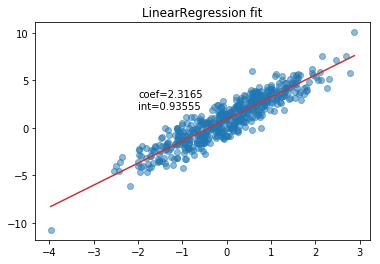

In [8]:
plt.scatter(x, y, alpha=0.5)
plt.plot(x, fit.predict(X), color='#CC3333')
plt.text(-2, 2, f'coef={fit.coef_[0]:0.05}\nint={fit.intercept_:0.05}')
plt.title('LinearRegression fit')
plt.show()

That worked nicely. But, what could go wrong?

## Measurement error

### 20% noise

In the previous example, our target variable y had some unaccounted-for noise added. But, our predictor variable was given to the model error-free. The real world is not often so kind. Let's add a little noise to predictor and see what happens. We'll start adding noise such that our signal is 20% noise and 80% predictor variable.

In [9]:
noise = 0.2
Xm = X + np.random.normal(scale=noise/(1-noise) * np.std(X), size=X.shape)
fit = LinearRegression().fit(Xm, y)
print('Xm.shape=', Xm.shape)
print('Xm std dev=', np.std(Xm))

Xm.shape= (500, 1)
Xm std dev= 1.0384761053710065


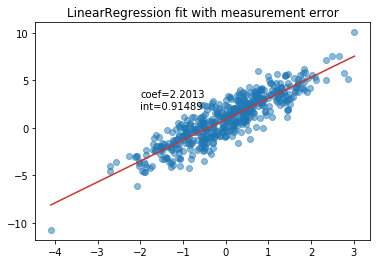

In [10]:
plt.scatter(Xm, y, alpha=0.5)
plt.plot(Xm, fit.predict(Xm), color='#CC3333')
plt.text(-2, 2, f'coef={fit.coef_[0]:0.05}\nint={fit.intercept_:0.05}')
plt.title('LinearRegression fit with measurement error')
plt.show()

### %50 noise

In [11]:
noise = 0.5
Xm = X + np.random.normal(scale=noise/(1-noise) * np.std(X), size=X.shape)
fit = LinearRegression().fit(Xm, y)
print('Xm.shape=', Xm.shape)

Xm.shape= (500, 1)


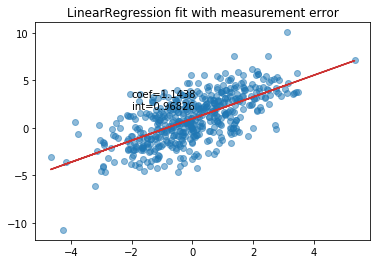

In [12]:
plt.scatter(Xm, y, alpha=0.5)
plt.plot(Xm, fit.predict(Xm), color='#CC3333')
plt.text(-2, 2, f'coef={fit.coef_[0]:0.05}\nint={fit.intercept_:0.05}')
plt.title('LinearRegression fit with measurement error')
plt.show()

### noise == signal

In [13]:
noise = 0.5
Xm = X + np.random.normal(scale=noise/(1-noise) * np.std(X), size=X.shape)
fit = LinearRegression().fit(Xm, y)
print('Xm.shape=', Xm.shape)

Xm.shape= (500, 1)


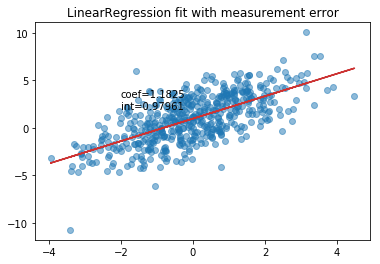

In [14]:
plt.scatter(Xm, y, alpha=0.5)
plt.plot(Xm, fit.predict(Xm), color='#CC3333')
plt.text(-2, 2, f'coef={fit.coef_[0]:0.05}\nint={fit.intercept_:0.05}')
plt.title('LinearRegression fit with measurement error')
plt.show()

### noise : signal == 2:1

In [15]:
noise = 2/3
Xm = X + np.random.normal(scale=noise/(1-noise) * np.std(X), size=X.shape)
fit = LinearRegression().fit(Xm, y)
print('Xm.shape=', Xm.shape)

Xm.shape= (500, 1)


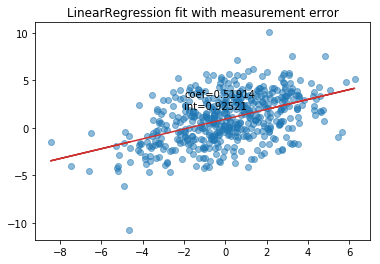

In [16]:
plt.scatter(Xm, y, alpha=0.5)
plt.plot(Xm, fit.predict(Xm), color='#CC3333')
plt.text(-2, 2, f'coef={fit.coef_[0]:0.05}\nint={fit.intercept_:0.05}')
plt.title('LinearRegression fit with measurement error')
plt.show()

## Underspecified regression models

In [17]:
n = 100
X = np.random.normal(size=(n,2))
x.sort()

In [18]:
beta = np.array([2.3456, 1.2345])
y = X @ beta + 20 + np.random.normal(size=n)

In [19]:
Xm = X[:,[0]] + np.random.normal(scale=0.2, size=(n,1))
fit = LinearRegression().fit(Xm, y)

In [20]:
print(f'coef={fit.coef_[0]:0.05} int={fit.intercept_:0.05}')

coef=2.372 int=20.254


In [21]:
Xm.shape

(100, 1)

In [22]:
y.shape

(100,)

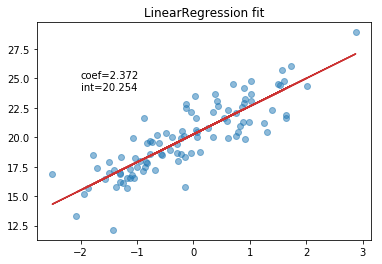

In [23]:
plt.scatter(Xm, y, alpha=0.5)
plt.plot(Xm, fit.predict(Xm), color='#CC3333')
plt.text(-2.0, 24, f'coef={fit.coef_[0]:0.05}\nint={fit.intercept_:0.05}')
plt.title('LinearRegression fit')
plt.show()

## Extraneous variables

In [24]:
n = 100
X = np.random.normal(size=(n,5))

In [25]:
beta = np.array([2.3456, 0.0, 0.0, 0.0, 0.0])
y = X @ beta + 20 + np.random.normal(size=n)

In [26]:
Xm = X

In [27]:
fit = LinearRegression().fit(Xm, y)

In [28]:
print(f'coef={fit.coef_} int={fit.intercept_:0.05}')

coef=[ 2.35961715  0.1245355  -0.01029134 -0.10485141 -0.06117353] int=20.086


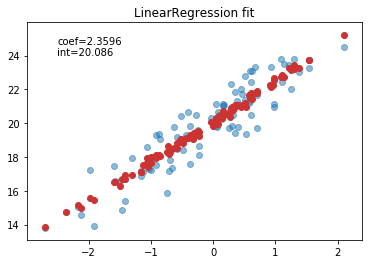

In [29]:
plt.scatter(X[:,0], y, alpha=0.5)
plt.scatter(X[:,0], fit.predict(Xm), color='#CC3333')
plt.text(-2.5, 24, f'coef={fit.coef_[0]:0.05}\nint={fit.intercept_:0.05}')
plt.title('LinearRegression fit')
plt.show()

## Overspecified regression model

In [30]:
n = 100
a = np.random.normal(size=n)
b = (2.0*a + np.random.normal(size=n))/3.0
c = (1.0*a + np.random.normal(size=n))/2.0
d = (0.5*a + np.random.normal(size=n))/1.5

In [31]:
np.corrcoef((a,b,c,d))[0]

array([1.        , 0.90379003, 0.69045412, 0.60684258])

In [32]:
X = np.stack((a,b,c,d),1)
X.shape

(100, 4)

In [33]:
beta = np.array([2.3456, 0.0, 0.0, 0.0])
y = X @ beta + 20 + np.random.normal(size=n)

In [34]:
fit = LinearRegression().fit(X, y)

In [35]:
print(f'coef={fit.coef_} int={fit.intercept_:0.05}')

coef=[ 2.42101637 -0.02864637  0.13364675 -0.20188586] int=20.033


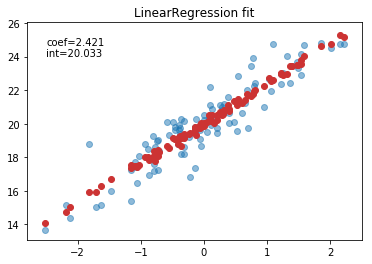

In [36]:
plt.scatter(X[:,0], y, alpha=0.5)
plt.scatter(X[:,0], fit.predict(X), color='#CC3333')
plt.text(-2.5, 24, f'coef={fit.coef_[0]:0.05}\nint={fit.intercept_:0.05}')
plt.title('LinearRegression fit')
plt.show()

## Missing Interactions

In [37]:
n = 100
a = np.random.normal(size=n)
b = np.random.normal(size=n)
c = 0.3333 * a * b

In [38]:
X = np.stack((a,b,c),1)
X.shape

(100, 3)

In [39]:
beta = np.array([1.3456, -0.378, 1.123])
y = X @ beta + 20 + np.random.normal(size=n)

In [40]:
Xm = X[:,0:2]

In [41]:
fit = LinearRegression().fit(Xm, y)

In [42]:
print(f'coef={fit.coef_} int={fit.intercept_:0.05}')

coef=[ 1.32331702 -0.3774058 ] int=20.124


## That was too easy

In [43]:
n = 100
a = np.random.normal(size=n)

## correlated. Non-normally distributed
b = (10.0*a + np.random.gamma(2.0, scale=5.0, size=n))/20.0

## interaction
c = np.random.normal(scale=0.2, size=n)
d = 0.5 * a * c

## correlated, error prone measurement
e = np.random.normal(size=n) + 0.1 * c

## unmeasured variable
f = np.random.normal(size=n) + 0.3 * c

In [44]:
X = np.stack((a,b,c,d,e,f),1)
X.shape

(100, 6)

In [45]:
beta = np.array([0.987, -0.378, 0.876, -0.123, -0.444, 0.900])
y = X @ beta + 20 + np.random.normal(size=n)

In [46]:
em = e.copy()

# oops
em[0], em[1] = em[1], em[0]
em[2], em[3] = em[3], em[2]

# uh-oh
em[4:14] = em.mean()

# zoinks
em[15] = max(em) * 2

In [47]:
noise= 0.2
Xm = np.stack((a,b,c,d,em),1) + np.random.normal(scale=noise, size=(n,5))
Xm.shape

(100, 5)

In [48]:
fit = LinearRegression().fit(Xm, y)

In [49]:
print(f'coef={fit.coef_} int={fit.intercept_:0.05}')

coef=[ 0.94074047 -0.25020669  0.34746517 -0.9850769  -0.1326251 ] int=19.973


### distribution of underspecified beta

In [50]:
n=100
trials = 1000
beta_est = []
for i in range(trials):
    a = np.random.normal(size=n)
    a.sort()
    b = 0.5 * a + 0.5 * np.random.normal(size=n)
    X = np.stack((a,b),1)
    beta = np.array([3, -2])
    y = X @ beta + np.random.normal(size=n) + 3
    Xm = X[:,0:1]
    fit = LinearRegression().fit(Xm, y)
    beta_est.append(fit.coef_[0])

In [51]:
np.mean(beta_est)

2.007231892942685

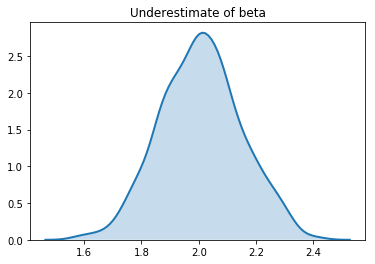

In [52]:
ax = plt.axes()
sns.distplot(beta_est, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2})
ax.set_title('Underestimate of beta')
plt.show()